IMPORT

You should have **Voxelizer.py** in your pyhton working folder (download it here https://github.com/MirkoZanon/Voxelizer).

In [1]:
import numan as nu
import vodex as vx
import Voxelizer as voxz
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython import display
%matplotlib inline
from tqdm.notebook import tqdm
import tifffile as tif

import analysis

FOLDERS AND DATA

The program assumes a main working folder inside which you should have a **'*mask.tif*' file** with a mask of ROIs defined by integers and a **'*/processed*' folder**.
This 'processed' folder is previously created by numan (after Notebook 02) and should contain an additional **'*/drift_corrected_af_to1000*'** folder with the truncated drift corrected files and their relative annotation (number+shape+spread labels) saved as **'*stimuli_truncated_timelines.csv*'**.
If these hierachies and names are not matching you have to modify them in the code below (or rename your original files)!

The process will create (if not existing) a folder inside the main path called '*/voxelizer_final_datasets*', where it will output a series of csv files for each ROI of the mask (file output name code: fishInfo_ROI#.csv)

The final csv is a table with super voxels as rows and stimulus time volumes as columns, with values corresponding to the df signal for each stimulus (avg in a window of 3 volumes from stimulus). This is what we need for classical ANOVA analysis. (The whole signal for all time volumes is instead inside variable *signals*).
Thus, final csv dimentions: SVs x stimulations 

In [2]:
# raw dataset folder and info
base_folder = "/Users/mirckuz/Desktop/20230601_Hz09_casper_h2bcamp7f_7dpf_60Z_1hzvol_2P_1v2v3v4v5_processed"
fishInfo = 'Hz09_casper_h2bcamp7f_7dpf'
analyze_SV_or_Imaris = 0 # 0 for Super Voxel analysis, 1 for Imaris spot analysis

# parameters for analysis
superVoxel_size = [3,5,5] # dimention of segmentation 'super voxel' in voxels. IMPORTANT, coordinates order: [z,y,x]
ROIs_to_analyze = [1,2,3,4] # define the ROIs you want to analyze (the ROI ID is the integer number relative to your mask)
truncated_stimulus_chunck_dimention = 9 # number of volumes in truncated window (remember python starts counting from zero)
normalization_frames = [0,1,2] # frames in truncated window to consider as F0 background for dF/F0 normalization
frames_per_volume = 60 # orginal frame per volume in raw numan experiment
starting_slice = 0 # orginal starting slice in raw numan experiment
n_vol_batch = 8 # number of volumes to load at a time for batch analysis

print('Note: you declared that your dataset is cut in \033[1mchunks of '+str(truncated_stimulus_chunck_dimention)+' volumes\033[0m. This info should be fulfilled by data in /drift_corrected_af_to1000 for a correct analysis!')

Note: you declared that your dataset is cut in chunks of 9 volumes. This info should be fulfilled by data in /drift_corrected_af_to1000 for a correct analysis!


In [3]:
os.chdir(base_folder) # set working directory to main raw data folder defined above
mask_file = "mask.tif"
annotations = pd.read_csv('./processed/stimuli_truncated_timelines.csv')
print('Loading experiment...')
experiment = vx.Experiment.from_dir('./processed/drift_corrected_af_to1000',frames_per_volume,starting_slice,verbose=False)
experiment.add_annotations_from_volume_annotation_df(annotations)
print('Time volumes: '+str(experiment.n_volumes)+'. Divisible by '+ str(truncated_stimulus_chunck_dimention)+': '+str(experiment.n_volumes%truncated_stimulus_chunck_dimention==0))
assert(experiment.n_volumes%truncated_stimulus_chunck_dimention==0)

Loading experiment...
Time volumes: 2160. Divisible by 9: True


In [4]:
if analyze_SV_or_Imaris == 1:

    my_spots = nu.Spots.from_json("./processed/spots/signals/spots_SvB_max.json")
    print('Normalizing signal...')
    dff = my_spots.signals.as_dff(method="step", step_size=truncated_stimulus_chunck_dimention, baseline_volumes=normalization_frames)
    signals = dff.traces.T

    stim_volumes = experiment.choose_volumes([("number","d1"), ("number","d2"), ("number","d3"),("number","d4"), ("number","d5")], logic = "or")
    stim_signal_exact = signals[:,stim_volumes]
    stim_signal_prov = np.zeros((stim_signal_exact.shape[0],stim_signal_exact.shape[1],3))
    stim_signal_prov[:,:,0] = stim_signal_exact
    for i in [1,2]: # add additional volume after stimulus to calculate final avg signal
        stim_add_volumes = [x+i for x in stim_volumes]
        stim_add_signal = signals[:,stim_add_volumes]
        stim_signal_prov[:,:,i] = stim_add_signal
    stim_signal = stim_signal_prov.mean(axis=2)
    print(' You obtained -> Cells X trials: ' + str(stim_signal.shape)+'\n')
        
    annotation_dict2= {f"cell_{ic}": stim_signal[ic] for ic in np.arange(len(signals))}
    annotation_dict=experiment.get_volume_annotations(stim_volumes)
    annotation_dict.update(annotation_dict2)
    annotation_df=pd.DataFrame(annotation_dict)

    #calculate control trials label array
    C_pd = pd.factorize((annotation_df['shape']+ annotation_df['spread']), sort=True)
    #C_pd = pd.factorize((annotation_df['shape']), sort=True)
    labelC = C_pd[1]
    C = np.array(C_pd[0])
    print('Control conditions label array, shape -> (trials,): ' + str(C.shape))


    #calculate stimulus trials label array
    Q_pd = pd.factorize(annotation_df['number'], sort=True)
    labelQ = Q_pd[1]
    Q = np.array(Q_pd[0])
    print('Stimulus label array, shape -> (trials,): ' + str(Q.shape))

    Hf = np.array(annotation_df.iloc[:, 4:annotation_df.shape[1]])
    print('Final dataset, shape -> (trials,cells): ' + str(Hf.shape))

    # merge the three array of interest Hf(data), Q(condition), C(control)
    final_labels = np.stack((C,Q),axis=1)
    total_df = np.concatenate((final_labels, Hf),axis=1)

    # save at /imaris_final_datasets
    if not os.path.exists('./imaris_final_datasets'):
        os.makedirs('./imaris_final_datasets')
    np.savetxt('./imaris_final_datasets/'+fishInfo+'.csv', total_df, delimiter=',')
    print('!FINAL ARRAY SAVED AS CSV!, shape -> (trials,2+cells): ' + str(total_df.shape))

    print('\033[1m\nDone! Your new raw dataset for Imaris based analysis is saved as csv file.\033[0m\nYou can find it in ./imaris_final_datasets folder.\nIf you want to anlayze it and check tunings run notebook 03c_Voxelizer_ANOVA_Nieder')

    # Configuration parameters
    Qrange = np.array([0,1,2,3,4]) # range of tested numerosities
    colors = ['red', 'orange', 'green', 'blue', 'purple'] # plotting colors for numerosities in Qrange
    matplotlib.rcParams.update({'font.size': 7.65}) # plot font size

    print('\nANALYSING with permutation ANOVA\n')

    # Find numorosity selective units (anova_cells) using a two-way ANOVA with permutations (permute data and check F distribution for p-value)
    pN, pC, pNC = analysis.anova_two_way_permutations(Q, C, Hf, 5000)
    anova_cells = np.where((pN<0.01) & (pNC>0.01) & (pC>0.01))[0]
    R = Hf[:,anova_cells]

    # Calculate and plot ditribution of preferred numerosities
    pref_num = analysis.preferred_numerosity(Q, R)
    hist = [np.sum(pref_num==q) for q in Qrange]
    hist /= np.sum(hist)

    print('Number of anova cells = %i (%0.2f%%)'%(len(anova_cells), 100*len(anova_cells)/Hf.shape[1]))
    plt.figure(figsize=(3,3))
    plt.bar(Qrange, 100*hist, width=0.8, color=colors)
    plt.xlabel('Preferred Numerosity')
    plt.ylabel('Percentage of cells')
    display.display(plt.gcf())

    # 1.Calculate average tuning curve of each unit
    tuning_curves = analysis.average_tuning_curves(Q, R)

        ### why not normalizing here????????
        # minim = np.repeat(np.min(tuning_curves, axis=0),tuning_curves.shape[0]).reshape(tuning_curves.shape[1],5).T
        # maxim = np.repeat(np.max(tuning_curves, axis=0),tuning_curves.shape[0]).reshape(tuning_curves.shape[1],5).T
        # print(tuning_curves.shape)
        # print(minim.shape)
        # tuning_curvesN = tuning_curves-minim/(maxim+minim)

        # 2.Calculate population tuning curves for each preferred numerosity
    tuning_mat = np.array([np.mean(tuning_curves[:,pref_num==q], axis=1) for q in Qrange]) # one row for each pref numerosity
    tuning_err = np.array([np.std(tuning_curves[:,pref_num==q], axis=1) / np.sqrt(np.sum(pref_num==q)) # standard error for each point on each tuning curve
                            for q in Qrange])

    # 3.Normalize population tuning curves to the 0-1 range
    tmmin = tuning_mat.min(axis=1)[:,None]
    tmmax = tuning_mat.max(axis=1)[:,None]
    tuning_mat = (tuning_mat-tmmin) / (tmmax-tmmin)
    tuning_err = tuning_err / (tmmax-tmmin) # scale standard error to be consistent with above normalization

    # Plot population tuning curves on linear scale
    plt.figure(figsize=(8,2.75))
    plt.subplot(1,2,1)
    for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
        plt.errorbar(Qrange, tc, err, color=colors[i])
        plt.xticks(Qrange)
    plt.xlabel('Numerosity')
    plt.ylabel('Normalized Neural Activity')

    # Plot population tuning curves on log scale
    plt.subplot(1,2,2)
    for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
        plt.errorbar(Qrange+1, tc, err, color=colors[i]) # offset x axis by one to avoid taking the log of zero
        plt.xscale('log', base=2)
        plt.gca().xaxis.set_major_formatter(ScalarFormatter())
        plt.xticks(ticks=Qrange+1, labels=Qrange+1)
    plt.xlabel('Numerosity')
    plt.ylabel('Normalized Neural Activity')
    display.display(plt.gcf())

    number_cells_dic = {}
    for i in range(anova_cells.shape[0]):
        number_cells_dic['sv_'+str(anova_cells[i])] = pref_num[i]+1
    


PROCESSING ROI 1

Voxelizing ROI 1... This could take time depending on your data and ROI size, but approx less than 20 min


Voxelizing chunks:   0%|          | 0/270 [00:00<?, ?it/s]

Normalizing signal in ROI 1...


Normalization cycles:   0%|          | 0/240 [00:00<?, ?it/s]

Preparing data table for ROI 1...
 You obtained -> SuperVoxels X trials: (3797, 240)

Control conditions label array, shape -> (trials,): (240,)
Stimulus label array, shape -> (trials,): (240,)
Final dataset ROI 1, shape -> (trials,cells): (240, 3797)
!FINAL ARRAY FOR ROI 1 SAVED AS CSV!, shape -> (trials,2+cells): (240, 3799)

Done! Your new raw datasets for Super Voxel based analysis are saved as separated csv files for each one of the ROIs you selected.
You can find them in ./voxelizer_final_datasets.
If you want to anlayze them and check tunings run notebook 03c_Voxelizer_ANOVA_Nieder

ANALYSING with ANOVA



Permutations:   0%|          | 0/5000 [00:00<?, ?it/s]

Number of anova cells for ROI1 = 509 (13.41%)


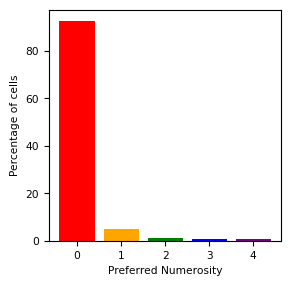

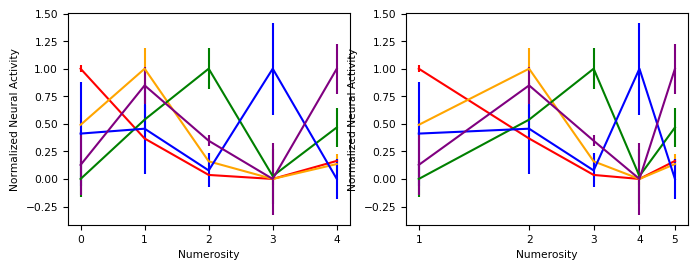


PROCESSING ROI 2

Voxelizing ROI 2... This could take time depending on your data and ROI size, but approx less than 20 min


Voxelizing chunks:   0%|          | 0/270 [00:00<?, ?it/s]

Normalizing signal in ROI 2...


Normalization cycles:   0%|          | 0/240 [00:00<?, ?it/s]

Preparing data table for ROI 2...
 You obtained -> SuperVoxels X trials: (10932, 240)

Control conditions label array, shape -> (trials,): (240,)
Stimulus label array, shape -> (trials,): (240,)
Final dataset ROI 2, shape -> (trials,cells): (240, 10932)
!FINAL ARRAY FOR ROI 2 SAVED AS CSV!, shape -> (trials,2+cells): (240, 10934)

Done! Your new raw datasets for Super Voxel based analysis are saved as separated csv files for each one of the ROIs you selected.
You can find them in ./voxelizer_final_datasets.
If you want to anlayze them and check tunings run notebook 03c_Voxelizer_ANOVA_Nieder

ANALYSING with ANOVA



Permutations:   0%|          | 0/5000 [00:00<?, ?it/s]

Number of anova cells for ROI2 = 5339 (48.84%)


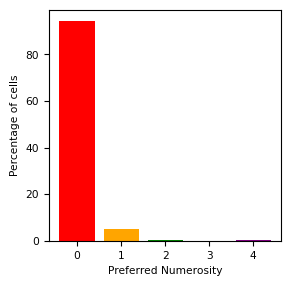

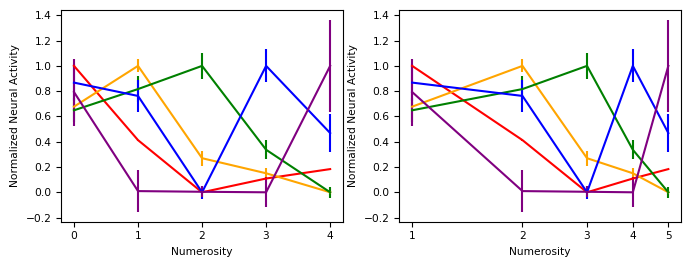


PROCESSING ROI 3

Voxelizing ROI 3... This could take time depending on your data and ROI size, but approx less than 20 min


Voxelizing chunks:   0%|          | 0/270 [00:00<?, ?it/s]

KeyboardInterrupt: 

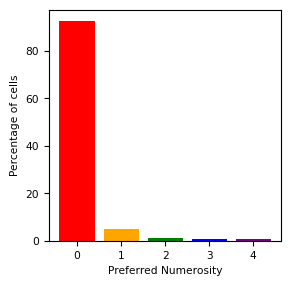

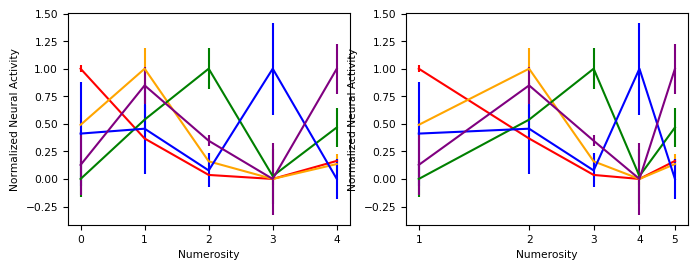

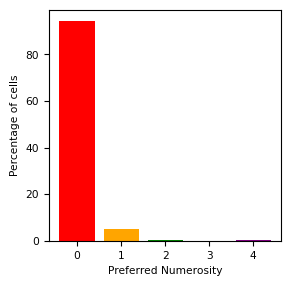

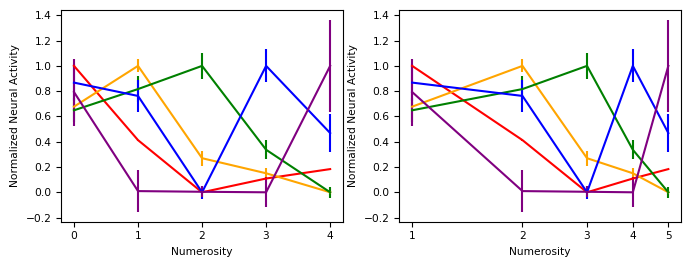

In [5]:
if analyze_SV_or_Imaris == 0:
    for roi in ROIs_to_analyze:
        print('\033[1m\nPROCESSING ROI '+str(roi)+'\033[0m\n')

        print('Voxelizing ROI '+str(roi)+'... This could take time depending on your data and ROI size, but approx less than 20 min')
        voxelizer = voxz.Voxelizer(mask_file, superVoxel_size, roi)
        table = voxelizer.process_movie(experiment, n_vol_batch)

        print('Normalizing signal in ROI '+str(roi)+'...')
        df = voxelizer.create_normalized_signal_df(table,truncated_stimulus_chunck_dimention,normalization_frames)
        signals = np.array(df).T
        
        print('Preparing data table for ROI '+str(roi)+'...')

        stim_volumes = experiment.choose_volumes([("number","d1"), ("number","d2"), ("number","d3"),("number","d4"), ("number","d5")], logic = "or")
        stim_signal_exact = signals[:,stim_volumes]
        stim_signal_prov = np.zeros((stim_signal_exact.shape[0],stim_signal_exact.shape[1],3))
        stim_signal_prov[:,:,0] = stim_signal_exact
        for i in [1,2]: # add additional volume after stimulus to calculate final avg signal
            stim_add_volumes = [x+i for x in stim_volumes]
            stim_add_signal = signals[:,stim_add_volumes]
            stim_signal_prov[:,:,i] = stim_add_signal
        stim_signal = stim_signal_prov.mean(axis=2)
        print(' You obtained -> SuperVoxels X trials: ' + str(stim_signal.shape)+'\n')
        
        annotation_dict2= {f"cell_{ic}": stim_signal[ic] for ic in np.arange(len(signals))}
        annotation_dict=experiment.get_volume_annotations(stim_volumes)
        annotation_dict.update(annotation_dict2)
        annotation_df=pd.DataFrame(annotation_dict)

        #calculate control trials label array
        C_pd = pd.factorize((annotation_df['shape']+ annotation_df['spread']), sort=True)
        #C_pd = pd.factorize((annotation_df['shape']), sort=True)
        labelC = C_pd[1]
        C = np.array(C_pd[0])
        print('Control conditions label array, shape -> (trials,): ' + str(C.shape))

        #calculate stimulus trials label array
        Q_pd = pd.factorize(annotation_df['number'], sort=True)
        labelQ = Q_pd[1]
        Q = np.array(Q_pd[0])
        print('Stimulus label array, shape -> (trials,): ' + str(Q.shape))

        Hf = np.array(annotation_df.iloc[:, 4:annotation_df.shape[1]])
        print('Final dataset ROI '+str(roi)+', shape -> (trials,cells): ' + str(Hf.shape))

        # merge the three array of interest Hf(data), Q(condition), C(control)
        final_labels = np.stack((C,Q),axis=1)
        total_df = np.concatenate((final_labels, Hf),axis=1)

        # save at /voxelizer_final_datasets
        if not os.path.exists('./voxelizer_final_datasets'):
            os.makedirs('./voxelizer_final_datasets')
        np.savetxt('./voxelizer_final_datasets/'+fishInfo+'_SV'+str(superVoxel_size[2])+'x'+str(superVoxel_size[1])+'x'+str(superVoxel_size[0])+'_ROI'+str(roi)+'.csv', total_df, delimiter=',')
        print('!FINAL ARRAY FOR ROI '+str(roi)+' SAVED AS CSV!, shape -> (trials,2+cells): ' + str(total_df.shape))

        print('\033[1m\nDone! Your new raw datasets for Super Voxel based analysis are saved as separated csv files for each one of the ROIs you selected.\033[0m\nYou can find them in ./voxelizer_final_datasets.\nIf you want to anlayze them and check tunings run notebook 03c_Voxelizer_ANOVA_Nieder')

        # Configuration parameters
        Qrange = np.array([0,1,2,3,4]) # range of tested numerosities
        colors = ['red', 'orange', 'green', 'blue', 'purple'] # plotting colors for numerosities in Qrange
        matplotlib.rcParams.update({'font.size': 7.65}) # plot font size

        print('\nANALYSING with permutation ANOVA\n')

        # Find numorosity selective units (anova_cells) using a two-way ANOVA with permutations (permute data and check F distribution for p-value)
        pN, pC, pNC = analysis.anova_two_way_permutations(Q, C, Hf, 3000)
        anova_cells = np.where((pN<0.01) & (pNC>0.01) & (pC>0.01))[0]
        R = Hf[:,anova_cells]

        # Calculate and plot ditribution of preferred numerosities
        pref_num = analysis.preferred_numerosity(Q, R)
        hist = [np.sum(pref_num==q) for q in Qrange]
        hist /= np.sum(hist)


        print('Number of anova cells for ROI'+str(roi)+' = %i (%0.2f%%)'%(len(anova_cells), 100*len(anova_cells)/Hf.shape[1]))
        plt.figure(figsize=(3,3))
        plt.bar(Qrange, 100*hist, width=0.8, color=colors)
        plt.xlabel('Preferred Numerosity')
        plt.ylabel('Percentage of cells')
        display.display(plt.gcf())

        # 1.Calculate average tuning curve of each unit
        tuning_curves = analysis.average_tuning_curves(Q, R)

        ### why not normalizing here????????
        # minim = np.repeat(np.min(tuning_curves, axis=0),tuning_curves.shape[0]).reshape(tuning_curves.shape[1],5).T
        # maxim = np.repeat(np.max(tuning_curves, axis=0),tuning_curves.shape[0]).reshape(tuning_curves.shape[1],5).T
        # print(tuning_curves.shape)
        # print(minim.shape)
        # tuning_curvesN = tuning_curves-minim/(maxim+minim)

        # 2.Calculate population tuning curves for each preferred numerosity
        tuning_mat = np.array([np.mean(tuning_curves[:,pref_num==q], axis=1) for q in Qrange]) # one row for each pref numerosity
        tuning_err = np.array([np.std(tuning_curves[:,pref_num==q], axis=1) / np.sqrt(np.sum(pref_num==q)) # standard error for each point on each tuning curve
                            for q in Qrange])

        # 3.Normalize population tuning curves to the 0-1 range
        tmmin = tuning_mat.min(axis=1)[:,None]
        tmmax = tuning_mat.max(axis=1)[:,None]
        tuning_mat = (tuning_mat-tmmin) / (tmmax-tmmin)
        tuning_err = tuning_err / (tmmax-tmmin) # scale standard error to be consistent with above normalization

        # Plot population tuning curves on linear scale
        plt.figure(figsize=(8,2.75))
        plt.subplot(1,2,1)
        for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
            plt.errorbar(Qrange, tc, err, color=colors[i])
            plt.xticks(Qrange)
        plt.xlabel('Numerosity')
        plt.ylabel('Normalized Neural Activity')

        # Plot population tuning curves on log scale
        plt.subplot(1,2,2)
        for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
            plt.errorbar(Qrange+1, tc, err, color=colors[i]) # offset x axis by one to avoid taking the log of zero
            plt.xscale('log', base=2)
            plt.gca().xaxis.set_major_formatter(ScalarFormatter())
            plt.xticks(ticks=Qrange+1, labels=Qrange+1)
        plt.xlabel('Numerosity')
        plt.ylabel('Normalized Neural Activity')
        display.display(plt.gcf())

        number_SVs_dic = {}
        for i in range(anova_cells.shape[0]):
            number_SVs_dic['sv_'+str(anova_cells[i])] = pref_num[i]+1

        #volume_matrix = tif.imread('ref_volume.tif')
        number_SVs_matrix = voxelizer.plot_SVs(number_SVs_dic)
        tif.imwrite('number_SVs_ROI'+str(roi)+'.tif', number_SVs_matrix)
